# Cross-validation
Once we develop a rule-based or ML-based strategy, it's time to backtest it. The first time around we obtain a low Sharpe ratio we're unhappy with, we decide to tweak our strategy. Eventually, after multiple iterations of tweaking parameters, we end up with a "flawless" combination of parameters and a strategy with an exceptional Sharpe ratio. However, in live trading the performance took a different turn: we essentially tanked and lost money. What went wrong?

Markets inherently have noise - small and frequent idiosyncrasies in the price data. When modelling a strategy, we want to avoid optimizing for one specific period because there is a chance the model adapts so closely to historical data that it becomes ineffective in predicting the future. It'd be like tuning a car specifically for one racetrack, while expecting it to perform well everywhere. Especially with vectorbt, which enables us to search extensive databases of historical market data for patterns, it is often possible to develop elaborate rules that appear to predict price development with close accuracy (see p-hacking) but make random guesses when applied to data outside the sample the model was constructed from.

Overfitting (aka curve fitting) usually occurs for one or more of the following reasons: mistaking noise for signal, and overly tweaking too many parameters. To curb overfitting, we should use cross-validation (CV), which involves partitioning a sample of data into complementary subsets, performing the analysis on one subset of data called the training or in-sample (IS) set, and validating the analysis on the other subset of data called the validation or out-of-sample (OOS) set. This procedure is repeated until we have multiple OOS periods and can draw statistics from these results combined. The ultimate questions we need to ask ourselves: is our choice of parameters robust in the IS periods? Is our performance robust on the OOS periods? Because if not, we're shooting in the dark, and as a quant investor we should not leave room for second-guessing when real money is at stake.

Consider a simple strategy around a moving average crossover.

First, we'll pull some data:

In [1]:
import numpy as np
import pandas as pd
from numba import njit

import vectorbtpro as vbt
vbt.settings.set_theme("dark")
vbt.settings.plotting["layout"]["width"] = 800
vbt.settings.plotting['layout']['height'] = 200
import warnings
warnings.filterwarnings("ignore")

/Users/ericervin/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


pull in some data

In [2]:
data = vbt.BinanceData.fetch("BTCUSDT", end="2022-11-01 UTC")
data.index

0it [00:00, ?it/s]

DatetimeIndex(['2017-08-17 00:00:00+00:00', '2017-08-18 00:00:00+00:00',
               '2017-08-19 00:00:00+00:00', '2017-08-20 00:00:00+00:00',
               '2017-08-21 00:00:00+00:00', '2017-08-22 00:00:00+00:00',
               '2017-08-23 00:00:00+00:00', '2017-08-24 00:00:00+00:00',
               '2017-08-25 00:00:00+00:00', '2017-08-26 00:00:00+00:00',
               ...
               '2022-10-22 00:00:00+00:00', '2022-10-23 00:00:00+00:00',
               '2022-10-24 00:00:00+00:00', '2022-10-25 00:00:00+00:00',
               '2022-10-26 00:00:00+00:00', '2022-10-27 00:00:00+00:00',
               '2022-10-28 00:00:00+00:00', '2022-10-29 00:00:00+00:00',
               '2022-10-30 00:00:00+00:00', '2022-10-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Open time', length=1902, freq='D')

Let's construct a parameterized mini-pipeline that takes data and the parameters, and returns the Sharpe ratio that should reflect the performance of our strategy on that test period:

### Modeling
The class Splitter can also be helpful in cross-validating ML models. In particular, you can casually step upon a class SKLSplitter that acts as a regular cross-validator from scikit-learn by subclassing BaseCrossValidator. We'll demonstrate its usage on a simple classification problem of predicting the best entry and exit timings.

Before we start, we need to decide on features and labels that should act as predictor and response variables respectively. Features are usually multi-columnar time-series DataFrames where each row contains multiple data points (one per column) that should predict the same row in labels. Labels are usually a single-columnar time-series Series that should be predicted. Ask yourself the following questions to easily come up with a decision:

"How can the future performance be represented, preferably as a single number? Should it be the price at the next bar, the average price change over the next week, a vector of weights for rebalancing, a boolean containing a signal, or something else?"
"What kind of data that encompasses the past performance is likely to predict the future performance? Should it be indicators, news sentiment index, past backtesting results, or something else?"
"Which ML model can handle such a task?" (remember that most models are limited to just a couple of specific feature and label formats!)
For the sake of an example, we'll fit a random forest classifier on all TA-Lib indicators stacked along columns to predict the binary labels generated by the label generator TRENDLB, where 1 means an uptrend and 0 means a downtrend. Sounds like fun 😌

First, run all the TA-Lib indicators on the entire data to get the feature set X:

In [3]:
X = data.run("talib")
print(f'The shape is {X.shape}')
print(f'The columns are {X.columns}')



The shape is (1902, 178)
The columns are MultiIndex([(    'acos',      'real'),
            (      'ad',      'real'),
            (     'add',      'real'),
            (   'adosc',      'real'),
            (     'adx',      'real'),
            (    'adxr',      'real'),
            (     'apo',      'real'),
            (   'aroon', 'aroondown'),
            (   'aroon',   'aroonup'),
            ('aroonosc',      'real'),
            ...
            (  'trange',      'real'),
            (   'trima',      'real'),
            (    'trix',      'real'),
            (     'tsf',      'real'),
            ('typprice',      'real'),
            (  'ultosc',      'real'),
            (     'var',      'real'),
            ('wclprice',      'real'),
            (   'willr',      'real'),
            (     'wma',      'real')],
           names=['run_func', 'output'], length=178)


If you're willing to accept a challenge: build a pipeline to impute and (standard-)normalize the data, [reduce the dimensionality](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html) of the features, as well as fit one of the [linear](https://scikit-learn.org/stable/modules/linear_model.html) models to predict the average price change over the next n bars (i.e., regression task!). Based on each prediction, you can then decide whether a position is worth opening or closing out. 

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from xgboost import XGBRegressor, XGBClassifier

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42) # random forest classifier

# data is a vbt.BinanceData object with OHLCV data for BTCUSDT

# Generate the features (X) using TA-Lib indicators
X = data.run("talib")
# add trend label as a feature
X['trend'] = data.run("trendlb", 1.0, 0.5, mode="binary").labels # add trend label as a feature

# Now we are trying to generate future price predictions so we will set the y labels to the price change n periods in the future
n = 20 # number of periods in the future to predict
y = (data.close.shift(-n) / data.close - 1).rolling(n).mean() # future price change we use rolling mean to smooth the data

# Preprocessing steps to handle NaNs
X = X.replace([-np.inf, np.inf], np.nan) # replace inf with nan
invalid_column_mask = X.isnull().all(axis=0) | (X.nunique() == 1) # drop columns that are all nan or have only one unique value
X = X.loc[:, ~invalid_column_mask] # drop invalid columns
invalid_row_mask = X.isnull().any(axis=1) | y.isnull() # drop rows that have nan in any column or in y

# Drop invalid rows in X and y
X = X.loc[~invalid_row_mask]
y = y.loc[~invalid_row_mask]


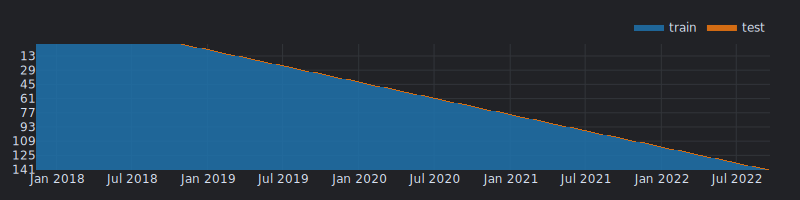

In [89]:

# Construct the pipeline
steps = [
    ('imputation', SimpleImputer(strategy='mean')),  # Imputation replaces missing values
    ('scaler', StandardScaler()),  # StandardScaler normalizes the data
    ('pca', PCA(n_components=20)),  # PCA reduces dimensionality
    
    # Choose one of the following models
    # ('model', Ridge())  # Ridge regression is used as the prediction model
    # ('model', LinearRegression())  # Linear regression is used as the prediction model
    # ('model', LogisticRegression())  # Logistic regression is used as the prediction model
    # ('model', Lasso())  # Lasso regression is used as the prediction model
    # ('model', ElasticNet())  # ElasticNet regression is used as the prediction model
    # ('model', SVR())  # Support Vector Regression is used as the prediction model
    ('model', XGBRegressor(objective='reg:squarederror'))  # XGBoost regression is used as the prediction model
]
pipeline = Pipeline(steps)

# Cross-validate
cv = vbt.SKLSplitter(
    "from_expanding",
    min_length=360,
    offset=10,
    split=-10,
    set_labels=["train", "test"]
)

cv_splitter = cv.get_splitter(X)
cv_splitter.plot().show_svg()


In [90]:
pipeline.fit(X, y)  # Fit the pipeline on the entire dataset    
print(f'Pipeline Score :{pipeline.score(X, y)}')  # Score the pipeline on the entire dataset
cross_val_score(pipeline, X, y, cv=cv, scoring="r2")

Pipeline Score :0.9811391773600939


array([-4.71802803e+00, -3.06220533e+01, -1.80265350e+02, -1.26509034e+01,
       -9.80551915e-01, -6.01253818e+02, -6.36915338e+00, -5.75841439e+02,
       -4.74867050e+01, -1.08399482e+01, -2.76307020e+02, -2.30837103e+00,
       -9.10644156e+02, -3.02064234e+00, -1.95567286e+01, -1.03925189e+02,
       -5.75157683e+00, -3.00453083e+00, -1.68524705e+01, -9.98976834e+00,
       -3.91291925e+00, -7.03016031e+01, -1.42125542e+01, -3.37069534e+01,
       -4.85947956e-01, -1.27282065e+01, -1.15197156e+01, -1.11713232e+01,
       -2.55460871e+01, -8.51948375e+01, -2.92991203e+00, -9.56669362e+00,
       -3.17444079e+01, -2.31019755e+01, -6.43792727e+00, -1.03094884e+01,
       -7.54702791e+00, -4.81133541e+00, -4.74469295e+02, -2.34460037e+01,
       -3.58469974e+01, -6.04945505e+00, -9.65508992e+00, -1.95140521e+02,
       -5.97743465e+00, -6.58363580e+01, -2.72300790e-01, -2.94044373e+00,
       -5.56826343e+00, -2.20389450e+02,  3.24179459e-01, -7.38406923e-01,
       -4.94324374e+00, -

In [91]:
X_slices = cv_splitter.take(X)
y_slices = cv_splitter.take(y)

test_labels = []
test_preds = []
for split in X_slices.index.unique(level="split"):  
    X_train_slice = X_slices[(split, "train")]  
    y_train_slice = y_slices[(split, "train")]
    X_test_slice = X_slices[(split, "test")]
    y_test_slice = y_slices[(split, "test")]
    slice_pipeline = pipeline.fit(X_train_slice, y_train_slice)  
    test_pred = slice_pipeline.predict(X_test_slice)  
    test_pred = pd.Series(test_pred, index=y_test_slice.index)
    test_labels.append(y_test_slice)
    test_preds.append(test_pred)

test_labels = pd.concat(test_labels).rename("labels")  
test_preds = pd.concat(test_preds).rename("preds")

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming test_labels and test_preds are your true and predicted values
mse = mean_squared_error(test_labels, test_preds)
rmse = np.sqrt(mse)  # or use mean_squared_error with squared=False
mae = mean_absolute_error(test_labels, test_preds)
r2 = r2_score(test_labels, test_preds)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")


Mean Squared Error (MSE): 0.01749781565302983
Root Mean Squared Error (RMSE): 0.13227930924006912
Mean Absolute Error (MAE): 0.10384948226958444
R-squared: 0.3169026493491036


In [78]:
data.close.vbt.overlay_with_heatmap(test_preds).show()

Start                          2018-10-30 00:00:00+00:00
End                            2022-07-30 00:00:00+00:00
Period                                1370 days 00:00:00
Start Value                                        100.0
Min Value                                      95.881053
Max Value                                     9149.13067
End Value                                     5805.81173
Total Return [%]                              5705.81173
Benchmark Return [%]                          273.463837
Total Time Exposure [%]                            100.0
Max Gross Exposure [%]                        119.768151
Max Drawdown [%]                               48.008241
Max Drawdown Duration                  264 days 00:00:00
Total Orders                                         158
Total Fees Paid                                      0.0
Total Trades                                         158
Win Rate [%]                                   50.318471
Best Trade [%]                 

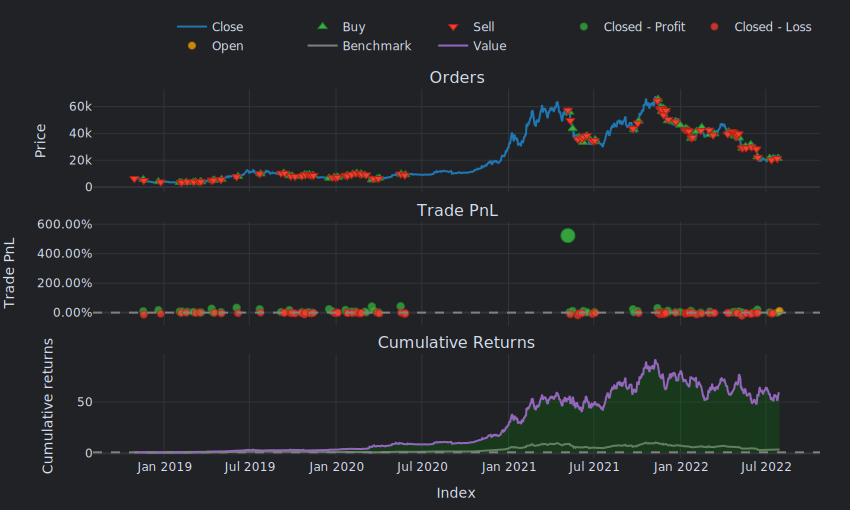

In [79]:
pf = vbt.Portfolio.from_signals(
    data.close[test_preds.index], # use only the test set
    test_preds > 0.0, # long when probability of price increase is greater than 2%
    test_preds < -0.05, # short when probability prediction is less than -5%
    direction="both" # long and short
)
print(pf.stats())
pf.plot().show_svg()

Check out how the look at a couple of different regimes

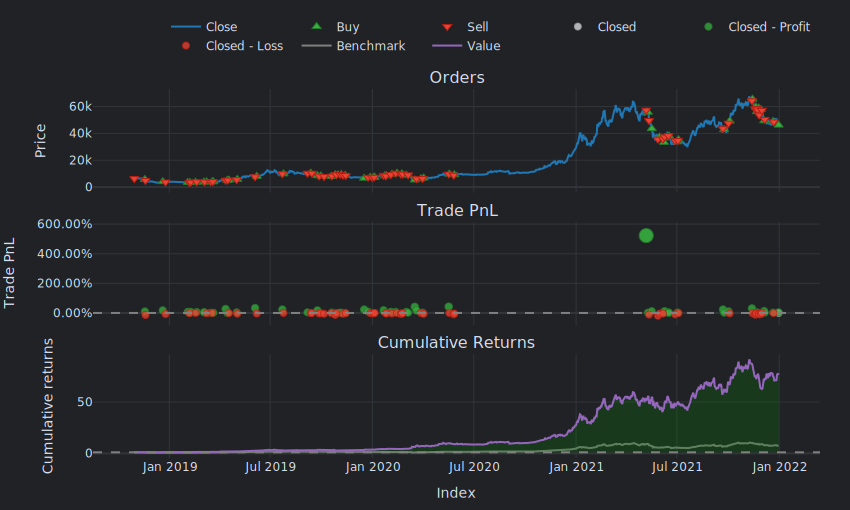

In [80]:
pf['2018':'2021'].plot().show_svg()


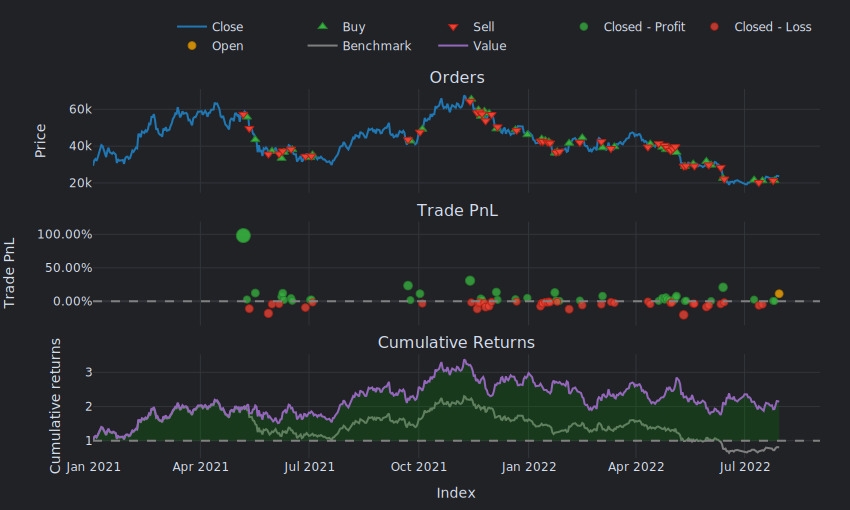

In [81]:
pf['2021':'2023'].plot().show_svg()